<a href="https://colab.research.google.com/github/Kallol7/PytorchNotes/blob/main/Pretrained/Pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import torch
from transformers import AutoModel, AutoFeatureExtractor, AutoModel, AutoConfig
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import albumentations as A
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T

In [ ]:
# https://huggingface.co/zongzhuofan/co-detr-vit-large-coco/resolve/main/pytorch_model.pth

from huggingface_hub import hf_hub_download

REPO_ID = "zongzhuofan/co-detr-vit-large-coco"
FILENAME = "pytorch_model.pth"

model_path = hf_hub_download(repo_id=REPO_ID, filename=FILENAME, local_dir ="model")

In [3]:
# model_path = "/content/model/pytorch_model.pth"
checkpoint = torch.load(
    model_path, weights_only=False
)

In [4]:
model_path = "/content/model"
os.rename(f"{model_path}/pytorch_model.pth", f"{model_path}/pytorch_model.bin")

In [5]:
model_config = AutoConfig.from_pretrained(REPO_ID)

In [6]:
model_config

DetrConfig {
  "_name_or_path": "zongzhuofan/co-detr-vit-large-coco",
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "attention_dropout": 0.0,
  "auxiliary_loss": false,
  "backbone": "resnet50",
  "backbone_config": null,
  "backbone_kwargs": {
    "in_chans": 3,
    "out_indices": [
      1,
      2,
      3,
      4
    ]
  },
  "bbox_cost": 5,
  "bbox_loss_coefficient": 5,
  "class_cost": 1,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "dice_loss_coefficient": 1,
  "dilation": false,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_coefficient": 0.1,
  "giou_cost": 2,
  "giou_loss_coefficient": 2,
  "init_std": 0.02,
  "init_xavier_std": 1.0,
  "is_encoder_decoder": true,
  "mask_loss_coefficient": 1,
  "model_type": "detr",
  "num_channels": 3,
  "num_hidden_layers": 6,
  "num_queries": 100,
  "p

In [ ]:
model = AutoModel.from_pretrained(model_path, config = model_config)

In [8]:
# height, width don't matter
random_batch = torch.randn(5,3, 190, 190)
model.eval()
model(random_batch).last_hidden_state.shape

torch.Size([5, 100, 256])

In [9]:
len(list(model.children()))

5

In [10]:
lenght_of_child_of_children = [len(list(child.children())) for child in model.children()]
lenght_of_child_of_children

[2, 0, 0, 1, 2]

In [11]:
data_folders =["test","train","valid"]

In [15]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/Dog Breed Classification/dog_breed.zip" -d "/content"

In [307]:
df = pd.read_csv("dogs.csv")
df.head(2)

,filepaths,labels,data set
0,train/Afghan/001.jpg,Afghan,train
1,train/Afghan/002.jpg,Afghan,train


In [308]:
# typo fix
df["labels"] = df["labels"].apply(lambda x: "American Spaniel" if x == "American  Spaniel" else x)

class_to_num = {label:name for (name,label) in enumerate(df["labels"].unique(),1)}
class_name = {num:name for (name,num) in class_to_num.items()}

print("{")
for i in range(1,10):
  print(f"  {i}: {class_name[i]}")
print("}")

{
  1: Afghan
  2: African Wild Dog
  3: Airedale
  4: American Hairless
  5: American Spaniel
  6: Basenji
  7: Basset
  8: Beagle
  9: Bearded Collie
}


In [309]:
df["labels"] = df["labels"].apply(lambda x:class_to_num[x])
df = df.iloc[:,:2]
df.head(3)

,filepaths,labels
0,train/Afghan/001.jpg,1
1,train/Afghan/002.jpg,1
2,train/Afghan/003.jpg,1


In [73]:
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df["labels"])
len(train_df), len(test_df)

(7944, 1402)

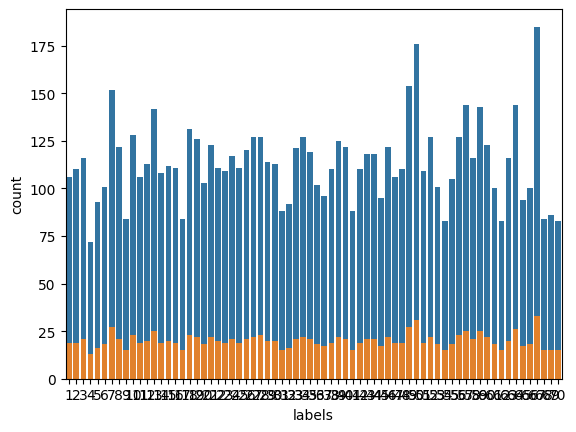

In [103]:
sns.countplot(data=train_df, x="labels")
sns.countplot(data=test_df, x="labels")
plt.show()

In [105]:
DATA_DIR = "/content/"
DEVICE = "cuda"
BATCH_SIZE = 16
LR = 0.001
EPOCHS = 5
MODEL_SAVE_PATH = "best.pt"

# Sample Image

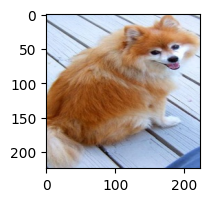

(224, 224, 3)

In [130]:
img = Image.open(os.path.join(DATA_DIR, train_df.iloc[5,0]))
_, ax = plt.subplots(1,1, figsize=(2,2))
ax.imshow(img)
plt.show()
np.shape(img)

# Augmentation

In [124]:
train_augms = A.Compose([
    A.Rotate(limit = (-15,15)),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomResizedCrop(scale = (.6,1), size = (128,128)),
    A.Normalize(mean = (.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

valid_augms = A.Compose([
    A.Resize(height=128, width=128),
    A.Normalize(mean = (.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

def denorm(channel_first_tensor_image):
  return channel_first_tensor_image.permute(1,2,0) * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))

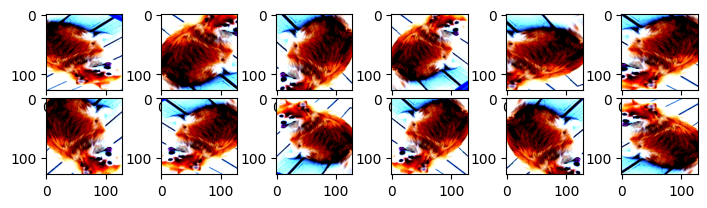

In [256]:
import logging

def show_image(img, aumentation = None, title = None, ax = None, plt_show = True, figsize=(8,8)):
  logger = logging.getLogger()
  old_level = logger.level
  logger.setLevel(100)

  if ax is None:
    if aumentation is not None:
      _, axes = plt.subplots(2,6,figsize=figsize)
      plt.subplots_adjust(left=0, bottom=0, right=0.85, top=0.2, wspace=0.1, hspace=0.1)

      for ax in axes.flatten():
        ax.imshow( aumentation(image = np.array(img))['image'] )
    else:
        plt.figure(figsize=(2,2))
        plt.imshow(img)

  else: # ax is provided
      ax.imshow( np.array(img) )

  if title is not None:
    if ax is None:
      plt.title(title)
    else:
      ax.set_title(title)

  if plt_show:
    plt.show()

  logger.setLevel(old_level)

show_image(img, train_augms)

# Load Dateset

In [314]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, directory, transforms=None):
        super().__init__()
        self.dataframe = dataframe
        self.data_dir = directory
        self.transforms = transforms

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = os.path.join(self.data_dir, self.dataframe.iloc[index, 0])
        image = Image.open(img_path)

        label = self.dataframe.iloc[index, 1]

        if self.transforms:
          image = self.transforms(image=np.array(image))['image']

        """Converts PIL or ndarray (H x W x C) range[0, 255]
        to a torch.FloatTensor (C x H x W) range [0.0, 1.0]"""
        image = T.ToTensor()(image)

        return image, label

In [315]:
# Create datasets
train_ds = ImageDataset(train_df, DATA_DIR, train_augms)
valid_ds = ImageDataset(test_df, DATA_DIR, valid_augms)

train_ds[43][0].shape, valid_ds[33][0].shape

(torch.Size([3, 128, 128]), torch.Size([3, 128, 128]))

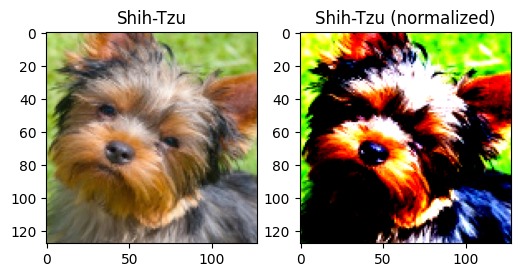

In [320]:
_channel_first_img,_label = train_ds[23]

_, ax = plt.subplots(1,2, figsize=(6,6))
ax = ax.flatten()

show_image(denorm(_channel_first_img), title = f"{class_name[_label]}", ax = ax[0], plt_show=False)
show_image(_channel_first_img.permute(1,2,0), title = f"{class_name[_label]} (normalized)", ax=ax[1])

In [321]:
print(f"Total training images {len(train_ds)}")
print(f"Total validation images {len(valid_ds)}")

Total training images 7944
Total validation images 1402


# Dataloader

In [323]:
train_dloader = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle=True)
valid_dloader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total batch in train loader : {len(train_dloader)}")
print(f"Total batch in valid loader : {len(valid_dloader)}")

Total batch in train loader : 497
Total batch in valid loader : 88
